# Commitment analysis experiments raw data viewer

This notebook takes the output of the 4-channel brightfield, gfp-h2b, rfp-h2b, irfp-pcna/JNK/p38 experiments, and displays the stacks and tracks in Napari.

In [11]:
import napari
print("Napari version no.:", napari.__version__)
import btrack
print('Btrack version', btrack.__version__)
import os, glob, enum
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from skimage.io import imread
from natsort import natsorted
from datetime import datetime
from btrack.utils import tracks_to_napari
from dask_image.imread import imread
import dask.array as da

Napari version no.: 0.4.11
Btrack version 0.4.2


### Set data folder and number of channels to display

In [4]:
### set root data folder
root_folder = '/home/nathan/data/kraken/commitment/'
expt_IDs = natsorted([ID for ID in os.listdir(root_folder) if 'MK' in ID])
print('Experiment/position list:', [(expt,natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])) for expt in expt_IDs])
@enum.unique
class channels(enum.Enum):
    bf = 0 
    gfp = 1
    rfp = 2
    irfp = 3
    #cp_masks = 4

Experiment/position list: [('MK0000', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0000v2', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0001', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0002', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0003', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15'])]


Select one position to view

In [5]:
expt = 'MK0003'
pos = 'Pos12'

# Launch napari (sans tracks)

In [7]:
file_pattern = os.path.join(root_folder, expt, pos, f'{pos}_stacks','{}.tif')
all_channels = [imread(file_pattern.format(channel.name)) for channel in channels]
print([(channel.value, channel.name) for channel in channels])
stack = da.stack(all_channels)
print('stack shape', stack.shape)  

### launch napari using channel.value indexes in stack
viewer = napari.Viewer()
#viewer.add_image(stack[0], name = "brightfield", contrast_limits=[0,200], blending = 'additive')#, is_pyramid=False)
viewer.add_image(stack[1], name="gfp", contrast_limits=[80,200], blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(stack[2], name="rfp", contrast_limits=[0,30], blending = 'additive', colormap = 'red')#, is_pyramid=False)
viewer.add_image(stack[3], name="irfp", contrast_limits=[0,200], blending = 'additive', colormap = 'cyan')#, is_pyramid=False)
#viewer.add_image(stack[4], name="masks", contrast_limits=[0,1], blending = 'additive')#, is_pyramid=False) 


[(0, 'bf'), (1, 'gfp'), (2, 'rfp'), (3, 'irfp')]
stack shape (4, 1200, 1352, 1688)


<Image layer 'irfp' at 0x7f91fdc29520>

# removing background

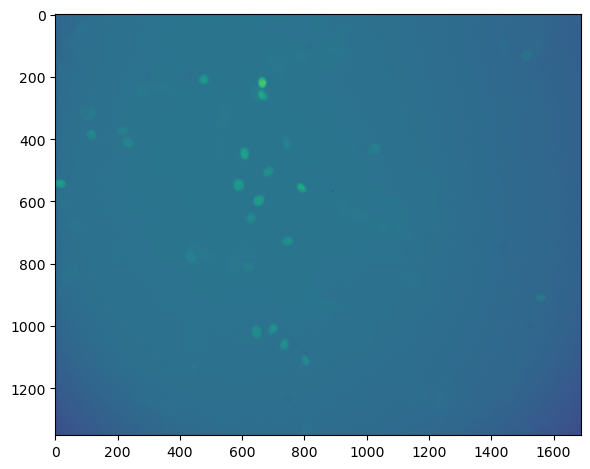

In [15]:
import matplotlib.pyplot as plt
plt.imshow(stack[1][0])
plt.show()

In [34]:
image = stack[0]

In [35]:
clean = remove_outliers(image)

In [ ]:
background = estimate_background(clean.astype(np.float32))

In [ ]:
plt.imshow(image[0] - background[0])
plt.show()

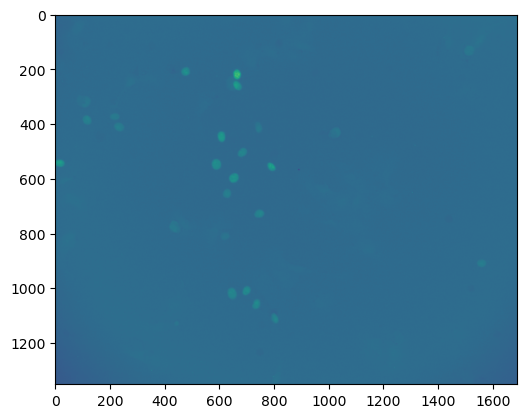

In [29]:
plt.imshow(image - background)
plt.show()

In [26]:
def estimate_background(x: np.ndarray) -> np.ndarray:
    """Estimate background using a second order polynomial surface.

    Estimate the background of an image using a second-order polynomial surface
    assuming sparse signal in the image.  Essentially a massive least-squares
    fit of the image to the polynomial.

    Parameters
    ----------
    x : np.ndarray
        An input image which is to be used for estimating the background.

    Returns
    -------
    background_estimate : np.ndarray
    	A second order polynomial surface representing the estimated background
        of the image.
    """

    # set up arrays for params and the output surface
    A = np.zeros((x.shape[0]*x.shape[1], 6))
    background_estimate = np.zeros((x.shape[1], x.shape[0]))

    u, v = np.meshgrid(
        np.arange(x.shape[1], dtype=np.float32),
        np.arange(x.shape[0], dtype=np.float32),
    )
    A[:, 0] = 1.
    A[:, 1] = np.reshape(u, (x.shape[0] * x.shape[1],))
    A[:, 2] = np.reshape(v, (x.shape[0] * x.shape[1],))
    A[:, 3] = A[:, 1] * A[:, 1]
    A[:, 4] = A[:, 1] * A[:, 2]
    A[:, 5] = A[:, 2] * A[:, 2]

    # convert to a matrix
    A = np.matrix(A)

    # calculate the parameters
    k = np.linalg.inv(A.T * A) * A.T
    k = np.squeeze(np.array(np.dot(k, np.ravel(x))))

    # calculate the surface
    background_estimate = k[0] + k[1]*u + k[2]*v + k[3]*u*u + k[4]*u*v + k[5]*v*v
    return background_estimate

from scipy.ndimage import median_filter

def remove_outliers(x):
    med_x = median_filter(x, size=2)
    mask = x > med_x
    x = x * (1-mask) + (mask*med_x)
    return x


### Load tracks

In [ ]:
tracking_fns = [fn for fn in glob.glob(data_folder+'/*.h5')]
[(i,fn) for i, fn in enumerate(tracking_fns)]

In [ ]:
tracking_fn = tracking_fns[0]

In [ ]:
with btrack.dataio.HDF5FileHandler(tracking_fn, 'r', obj_type = "obj_type_3") as hdf:
    tracks_ = hdf.tracks
tracks, properties, graph = tracks_to_napari(tracks_, ndim = 2)

### Load many tracks

In [ ]:
tracks_path = natsorted(glob.glob('/run/user/1000/gvfs/smb-share:server=lowe-sn00.biochem.ucl.ac.uk,share=lowegrp/Data/Manasi/{}/{}/*.h5'.format(expt, pos)))
[(i, name) for i,name in enumerate(tracks_path)]

In [ ]:
gfp_tracks = tracks_path[2]
rfp_tracks = tracks_path[5]
irfp_tracks = tracks_path[3]

with btrack.dataio.HDF5FileHandler(irfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    wt2_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(gfp_tracks, 'r', obj_type = "obj_type_3") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(rfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

### Launch napari avec tracks

In [ ]:
### launch napari
#with napari.gui_qt():
viewer = napari.Viewer()
viewer.add_image(stack[0], name = "brightfield", contrast_limits=[0,200], blending = 'additive')#, is_pyramid=False)
viewer.add_image(stack[1], name="gfp", contrast_limits=[80,200], blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(stack[2], name="rfp", contrast_limits=[0,30], blending = 'additive', colormap = 'red')#, is_pyramid=False)
viewer.add_image(stack[3], name="irfp", contrast_limits=[0,200], blending = 'additive', colormap = 'cyan')#, is_pyramid=False)
#viewer.add_image(stack[4], name="masks", contrast_limits=[0,1], blending = 'additive')#, is_pyramid=False) 

## add tracks
#viewer.add_tracks(tracks)
#viewer.add_tracks(irfp_tracks)
#viewer.add_tracks(scr_tracks)
napari.run()

# Alan's code

need to rejig a bit

In [ ]:
import sys
sys.path.append('../simple-unet')
from daskoctopus import DaskOctopusLiteLoader

In [ ]:
PATH = '/home/nathan/data/kraken/commitment/MK0003/Pos0/Pos0_raw'

In [ ]:
reader = DaskOctopusLiteLoader(
    PATH, 
    crop=(1200, 1600),
    remove_background=False,
)

In [ ]:
gfp = reader["gfp"]
files = reader.files("gfp")

In [ ]:
viewer = napari.Viewer()
viewer.add_image(gfp)